# MACD 交易策略

## 交易邏輯
* 利用兩條不同速度的快慢EMA(指數移動平均線)交錯來判斷股價走勢。
* 比較兩條長短天數的指數移動平均線(EMA)，相減算出 差離值(DIF)後，對差離值再進行一次指數移動平均線的計算。
* EMA(n)=(前一日EMA(n) × (n-1)+今日收盤價 × 2) ÷ (n+1)
* EMA(m)=(前一日EMA(m) × (m-1)+今日收盤價 × 2) ÷ (m+1)
* DIF=EMA(n)－EMA(m)
* MACD(x)=(前一日xMACD × (x-1)+DIF × 2) ÷ (x+1)
* 其中n, m, x分別代表快線天數、慢線天數與DIF的x日指數移動平均線
* ※短期EMA常使用12日、長期EMA常使用26日、DIF常使用9日來比較。

## 交易策略
* 當快線往上突破慢線，且MACD柱由負轉正，被視為黃金交叉(預測市場會上漲)，表示後續可能會有一波漲幅，視為買入信號。
* 當快線向下跌破慢線，且MACD柱由正轉負，被視死亡交叉(預測市場會下跌)，表示後續可能會有一波跌幅可能，視為賣出信號。

## 參考來源
https://www.tejwin.com/insight/%e3%80%90%e9%87%8f%e5%8c%96%e5%88%86%e6%9e%90%e3%80%91macd%e6%8c%87%e6%a8%99%e5%9b%9e%e6%b8%ac%e5%af%a6%e6%88%b0/


## 導入資料與套件
資料導入階段，我們使用 `os.environ` 設置環境變數，分別設定:

1. TEJAPI_BASE: 為欲連結的網域名稱
2. TEJAPI_KEY: 為購買 Tquant Lab 隨附的 api key，用於驗證個人身分。
3. mdate: 所欲抓取資料的時間範圍，格式為 "西元年份月份日期 西元年份月份日期"。
4. ticker: 所欲抓取資料的股價代碼。

於本次案例我們抓取台積電股價資料，時間區間設定為 2018-12-30 到 2023-05-26 之間。



In [134]:
import os    
import pandas as pd
import numpy as np

os.environ['TEJAPI_BASE'] = 'https://api.tej.com.tw'
os.environ['TEJAPI_KEY'] = 'LW5NpOFwTqE5QCMVf97lhQKhDs3V9u'
os.environ['mdate'] = '20181230 20230526'
os.environ['ticker'] = '2330'

# 使用 ingest 將股價資料導入暫存，並且命名該股票組合 (bundle) 為 tquant
!zipline ingest -b tquant 


[2023-08-23 05:37:21.335994] INFO: zipline.data.bundles.core: Ingesting tquant.
Merging daily equity files:  [####################################]   


## 編輯交易策略
### 導入所需套件

In [135]:
import talib
from zipline.api import order_target, record, symbol
from zipline.finance import commission, slippage
import matplotlib.pyplot as plt

## 建立Algorithm
每個 zipline 程序都必須先定義兩個的`function`，`initialize()` 與 `handle_data()`。

在執行程序前必須先呼叫`initialize()`定義 __context__ 變數。
__context__ 是一個讓您能儲存回測資訊的 persistent namespace ，它提供了高度的自由讓使用者可以客製化自己的回測情境。

初始化程序後，zipline 會在為每次事件調用 `handle_data()`函數。每次調用時，它都會傳遞相同的 __context__ 變數和一個叫做 __data__ 的 event-frame， 其中包含當前交易欄的開盤價、最高價、最低價和收盤價 (OHLC) 以及您的投資組合中每隻股票的交易量。

最後，我們可以定義函式`analyze()`來對交易策略進行績效評估與視覺化。
請注意，`analyze()`在執行程式時是一個 optional 的功能。



### 建立 initialize 函式

`inintialize` 函式用於定義交易開始前的交易環境，與此例中我們設置:

* 股票代號
* 持有股數
* 是否持有部位
* 交易手續費
* 流動性滑價



In [136]:
def initialize(context):
    context.sym = symbol('2330')
    context.i = 0
    context.invested = False
    context.set_commission(commission.PerDollar(cost=0.00285))
    context.set_slippage(slippage.VolumeShareSlippage())

## 建立 handle_date 函式
`handle_data` 函式用於處理每天的交易策略或行動，其中:

* condition1: 當快線往上突破慢線，且持有部位為0，視為買入信號。
* condition2: 當快線向下跌破慢線，且持有部位不為0，視為賣出信號。


In [143]:
def handle_data(context, data):
    trailing_window = data.history(context.sym, 'price', 35, '1d')#35 = 26 + 9
    if trailing_window.isnull().values.any():
        return
    
    short_ema = talib.EMA(trailing_window.values, timeperiod = 12)
    long_ema = talib.EMA(trailing_window.values, timeperiod = 26)
    dif = short_ema - long_ema
    MACD = talib.EMA(dif, timeperiod = 9)
    bar = dif - MACD
    
    buy = False
    sell = False

    # Trading logic
    #condition1     
    if (dif[-2] < MACD[-2]) and (dif[-1] > MACD[-1]) and (bar[-2] < 0) and (bar[-1] > 0):

        order_target(context.sym, 1000)
        context.invested = True
        buy = True
        
    #condition2
    elif (dif[-2] > MACD[-2]) and (dif[-1] < MACD[-1]) and (bar[-2] > 0) and (bar[-1] < 0) and context.invested:
        order_target(context.sym, 0)
        context.invested = False
        sell = True

    # Save values for later inspection
    record(TSMC = data.current(symbol('2330'), 'close'),         
           dif = dif[-1],
           MACD = MACD[-1],
           bar = bar[-1],
           buy = buy,
           sell = sell)
    

## 建立 analyze 函式

在`analyze`中使用 __matplotlib.pyplot__ 繪製 投資組合價值折線圖 與 MACD 指標圖

In [155]:
# Note: this function can be removed if running
# this algorithm on quantopian.com
def analyze(context=None, results=None):
    import matplotlib.pyplot as plt
    import logbook
    logbook.StderrHandler().push_application()
    log = logbook.Logger('Algorithm')

    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    results.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('Portfolio value (TWD)')

    ax2 = fig.add_subplot(212, sharex = ax1)
    ax2.set_ylabel('MACD')

    # If data has been record()ed, then plot it.
    # Otherwise, log the fact that no data has been recorded.
    if 'dif' in results and 'MACD' in results:
        results[['dif', 'MACD']].plot(ax=ax2)
        ax2.plot(
            results.index[results["buy"] == True],
            results.loc[results["buy"] == True, 'MACD'],
            '^',
            markersize=10,
            color='m',
        )
        ax2.plot(
            results.index[results["sell"] == True],
            results.loc[results["sell"] == True, 'MACD'],
            'v',
            markersize=10,
            color='k',
        )

        ax3 = ax2.twinx()
        colors = ["red" if i > 0 else "green" for i in results['bar']]
        ax3.bar(results.index, results['bar'], color=colors, alpha=0.5, width=0.4, label='MACD Bar')
        
        lines, labels = ax2.get_legend_handles_labels()
        bars, bar_labels = ax3.get_legend_handles_labels()
        ax2.legend(lines + bars, labels + bar_labels, loc='upper right')
        
        plt.gcf().set_size_inches(18, 8)

    else:
        msg = 'TSMC - dif and MACD data not captured using record().'
        ax2.annotate(msg, xy=(0.1, 0.5))
        log.info(msg)

    plt.show()

## 執行交易策略

使用 `run_algorithm` 執行上述所編撰的交易策略，設置交易期間為 2018-12-30 到 2023-05-26，初始資金為 100,000 元，所使用資料集為 *tquant*，其中輸出的變數 __results__ 就是每日績效與交易的明細表。

[2023-08-23 07:01:06.107587] INFO: Performance: Equity(0 [2330]), cash_dividend amount: 8.0, pay_date: 2019-07-18, div_owed: 8000.0
[2023-08-23 07:01:06.237962] INFO: Performance: Equity(0 [2330]), cash_dividend amount: 2.0, pay_date: 2019-10-17, div_owed: 2000.0
[2023-08-23 07:01:06.368012] INFO: Performance: Equity(0 [2330]), cash_dividend amount: 2.5, pay_date: 2020-01-16, div_owed: 2500.0
[2023-08-23 07:01:06.613176] INFO: Performance: Equity(0 [2330]), cash_dividend amount: 2.5, pay_date: 2020-07-16, div_owed: 2500.0
[2023-08-23 07:01:06.746925] INFO: Performance: Equity(0 [2330]), cash_dividend amount: 2.5, pay_date: 2020-10-15, div_owed: 2500.0
[2023-08-23 07:01:07.137171] INFO: Performance: Equity(0 [2330]), cash_dividend amount: 2.5, pay_date: 2021-07-15, div_owed: 2500.0
[2023-08-23 07:01:07.287506] INFO: Performance: Equity(0 [2330]), cash_dividend amount: 2.75, pay_date: 2021-10-14, div_owed: 2750.0
[2023-08-23 07:01:07.658584] INFO: Performance: Equity(0 [2330]), cash_divi

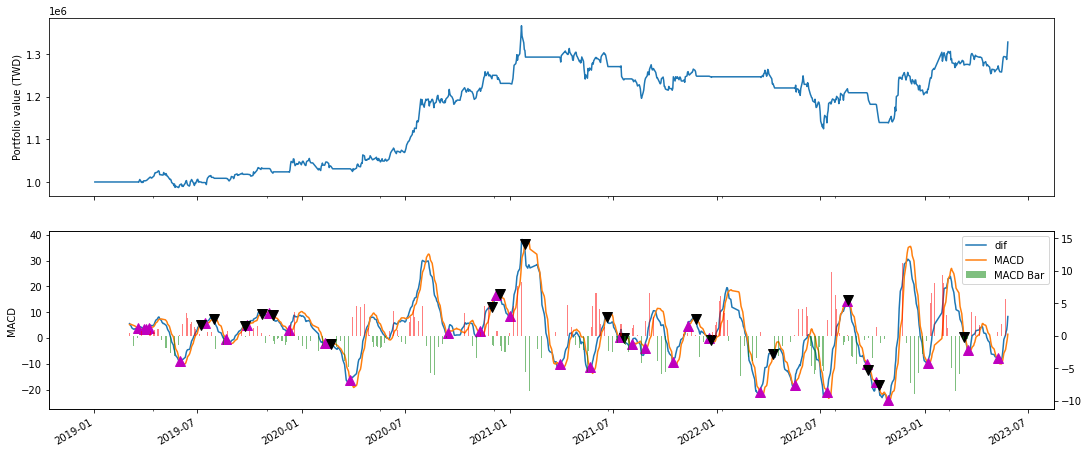

In [156]:
from zipline import run_algorithm

start_date = pd.Timestamp('2018-12-30',tz='utc')
end_date = pd.Timestamp('2023-05-26',tz='utc')

results = run_algorithm(start= start_date,  
                       end=end_date,
                       initialize=initialize,                       
                       capital_base=1e6,
                       analyze=analyze,
                       handle_data=handle_data,
                       data_frequency='daily',
                       bundle='tquant'
                       )

In [154]:
results

,period_open,period_close,benchmark_return,portfolio_value,positions,longs_count,gross_leverage,starting_exposure,short_exposure,pnl,...,algo_volatility,max_drawdown,max_leverage,treasury_period_return,TSMC,dif,MACD,bar,buy,sell
2019-01-02 13:30:00+08:00,2019-01-02 09:01:00+08:00,2019-01-02 13:30:00+08:00,0.0,1.000000e+06,[],0,0.000000,0.0,0.0,0.0,...,NaN,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03 13:30:00+08:00,2019-01-03 09:01:00+08:00,2019-01-03 13:30:00+08:00,0.0,1.000000e+06,[],0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04 13:30:00+08:00,2019-01-04 09:01:00+08:00,2019-01-04 13:30:00+08:00,0.0,1.000000e+06,[],0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-07 13:30:00+08:00,2019-01-07 09:01:00+08:00,2019-01-07 13:30:00+08:00,0.0,1.000000e+06,[],0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-08 13:30:00+08:00,2019-01-08 09:01:00+08:00,2019-01-08 13:30:00+08:00,0.0,1.000000e+06,[],0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-22 13:30:00+08:00,2023-05-22 09:01:00+08:00,2023-05-22 13:30:00+08:00,0.0,1.294057e+06,"[{'sid': Equity(0 [2330]), 'amount': 1000, 'co...",1,0.410337,532000.0,0.0,-1000.0,...,0.084263,-0.177213,0.494637,0.0,531.0,1.145142,-4.532980,5.678121,False,False
2023-05-23 13:30:00+08:00,2023-05-23 09:01:00+08:00,2023-05-23 13:30:00+08:00,0.0,1.293057e+06,"[{'sid': Equity(0 [2330]), 'amount': 1000, 'co...",1,0.409881,531000.0,0.0,-1000.0,...,0.084225,-0.177213,0.494637,0.0,530.0,2.439485,-3.212420,5.651905,False,False
2023-05-24 13:30:00+08:00,2023-05-24 09:01:00+08:00,2023-05-24 13:30:00+08:00,0.0,1.288057e+06,"[{'sid': Equity(0 [2330]), 'amount': 1000, 'co...",1,0.407591,530000.0,0.0,-5000.0,...,0.084209,-0.177213,0.494637,0.0,525.0,3.097344,-1.945854,5.043198,False,False
2023-05-25 13:30:00+08:00,2023-05-25 09:01:00+08:00,2023-05-25 13:30:00+08:00,0.0,1.306057e+06,"[{'sid': Equity(0 [2330]), 'amount': 1000, 'co...",1,0.415755,525000.0,0.0,18000.0,...,0.084434,-0.177213,0.494637,0.0,543.0,5.007625,-0.467820,5.475445,False,False
